In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

from pymc3.gp.util import plot_gp_dist
import cmdstanpy as stan
import arviz as az

from tqdm import tqdm

In [3]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

In [5]:
%load_ext stanmagic

# Utility models

In [6]:
def u_pow(x, theta): return x**theta

In [7]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

In [8]:
def u_lin(x, theta=None): return x

# Generate choice data

In [9]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [10]:
data = generate_data(u=u_pow, n=1000, tau=3.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,1
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,0
5796,0.116159,0.356232,0.732859,0.310642,0
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,1
8834,0.980679,0.073375,0.877985,0.777087,1


# Likelihood whole model given M, $\theta_M$

In [11]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [12]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [13]:
optimize(data, u_m=u_pow)

array([3.28496491, 0.53506426])

# Measure discrepancy

## Define model

In [14]:
%%stan -f gp_model.stan -v gp_model --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
data {
  int<lower=0> N;
  int<lower=0> N_y;
  vector<lower=0, upper=1>[N] p;
  vector[N] X;
  int<lower=0, upper=1> y[N_y];
  int belong0[N_y];
  int belong1[N_y];
  real tau;
  real jitter;
  vector[N] mu;
  matrix[N, N] kernel_factor;
}
transformed data {
  matrix[N, N] diag_jitter;
  real X_array[N];
  diag_jitter = diag_matrix(rep_vector(jitter, N));
  X_array = to_array_1d(X);
}
parameters {
  real<lower=0> kernel_length;
  real<lower=0> kernel_var; 
  vector[N] eta;
}
transformed parameters{
}
model {
  vector[N] seu;
  vector[N_y] seu0;
  vector[N_y] seu1;
  vector[N_y] diff_eu;
  matrix[N, N] L;
  matrix[N, N] K;
  vector[N] f;
  
  kernel_length ~ normal(1, 1);
  kernel_var ~ normal(1, 1);
  eta ~ std_normal();
  
  K = kernel_factor .* gp_exp_quad_cov(X_array, kernel_var, kernel_length) + diag_jitter;
  L = cholesky_decompose(K);
  
  f = mu + L*eta;
  
  seu = p .* f;
  seu0 = seu[belong0];
  seu1 = seu[belong1];
  diff_eu = seu1 - seu0;
  y ~ bernoulli_logit(tau * diff_eu);
}
generated quantities {
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/936d3c49-832c-480f-8a41-e84848a6c540.cpp gp_model.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in gp_model object.
Type gp_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^
Access model compile output properties
gp_model.model_file -> Name of stan_file [gp_model.stan]
gp_model.model_name -> Name of stan model [gp_model_model]
gp_model.model_code -> Model code [data {   int<lower=0 ....]


In [15]:
stan_model = stan.CmdStanModel(stan_file=gp_model.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/gp_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/gp_model


In [16]:
def prepare_data_for_stan(data, u, theta, tau):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    # mu = x_sorted
    # kernel_factor = x_sorted*x_sorted[:, None]
    mu = u(x_sorted, theta)
    kernel_factor = mu*mu[:, None]
    
    N = len(x)
    N_y = len(y)
    belong0 = undo_sorted[:N_y]
    belong1 = undo_sorted[N_y:]
    
    assert kernel_factor.shape == (N, N)

    return {
        ''
        'tau': tau,
        'p': p_sorted,
        'X': x_sorted,
        'y': y,
        'N_y': N_y,
        'N': N,
        'jitter': 1e-06,
        'belong0': belong0 + 1,
        'belong1': belong1 + 1,
        'mu': mu,
        'kernel_factor': kernel_factor
    } 

## With 'bad' prior

In [17]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333
data = generate_data(u=u_data, theta=theta_data, tau=tau_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(100, replace=False)

In [18]:
optimize(data)

array([3.4444072 , 0.39557323])

In [19]:
u_model = u_lin # u_data
theta_model = None # theta_data
tau_model = 3.333

In [20]:
stan_data = prepare_data_for_stan(data, u=u_model, theta=theta_model, tau=tau_model)

In [21]:
trace = stan_model.sample(data=stan_data, show_progress="notebook", chains=2)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
samples_az = az.from_cmdstanpy(trace)

### Make predictions

In [79]:
def kernel(X, Xs, length):
    deltaX = np.power((X[:, None] - Xs) / length, 2.0)
    return np.exp(-0.5 * deltaX)

def gp_predict(X, samples_az, u, theta, Xnew=None, jitter=1.0e-6, use_ratio=True):
    
    n_sample = samples_az.posterior["kernel_var"].shape[0] * samples_az.posterior["kernel_var"].shape[1]
    
    var_samples = np.array(samples_az.posterior["kernel_var"]).reshape(n_sample, -1)
    length_samples = np.array(samples_az.posterior["kernel_length"]).reshape(n_sample, -1)
    eta_samples = np.array(samples_az.posterior["eta"]).reshape(n_sample, -1)
    
    N = X.shape[0]
    
    if Xnew is not None:
        f_predict = np.zeros((n_sample, Xnew.shape[0]))

    else:
        f_predict = np.zeros((n_sample, N))
        
    uX = u(X, theta_model)

    if use_ratio:
        factor = uX[:, None] * uX
    else:
        factor = 1
    
    for i in tqdm(range(n_sample)):
    
        var=var_samples[i]
        length=length_samples[i]
        eta=eta_samples[i] 

        k_XX = factor * var**2 * kernel(X, X, length) + jitter*np.eye(N)
        L = np.linalg.cholesky(k_XX)
        L_eta = L.dot(eta)

        if Xnew is not None:

            up = u(Xnew, theta)

            if use_ratio:
                factor_Xp = uX[:, None] * up
            else:
                factor_Xp = 1
            
            K_Xp = factor_Xp * var**2 * kernel(X, Xnew, length)

            A = scipy.linalg.solve_triangular(L, K_Xp, lower=True)
            v = scipy.linalg.solve_triangular(L, L_eta, lower=True)
            
            f_predict[i] = up + A.T.dot(v)

        else:
            f = uX + L_eta
            f_predict[i] = f
    
    return f_predict

In [80]:
f_samples = gp_predict(X=stan_data["X"], samples_az=samples_az, 
                       u=u_model, theta=theta_model, use_ratio=True,
                       Xnew=None)

100%|██████████| 2000/2000 [00:03<00:00, 654.10it/s]


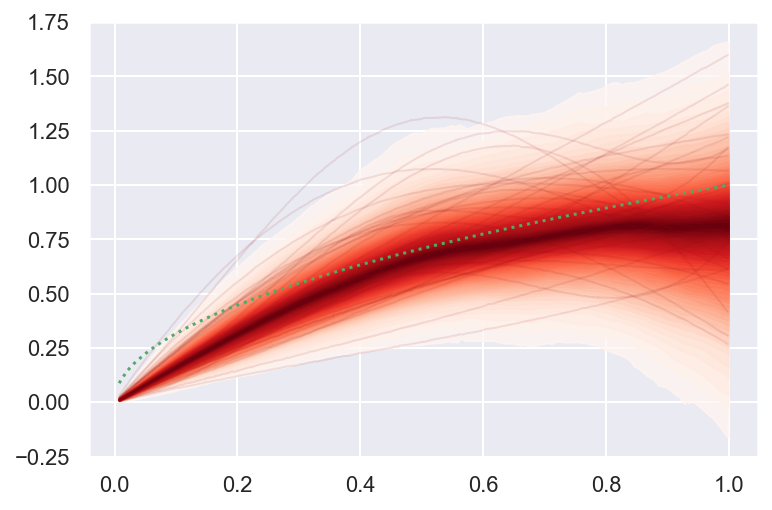

In [82]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, stan_data["X"])
# ax.plot(X, u_model(X, theta=theta_model), ls="--");
ax.plot(stan_data["X"], u_data(stan_data["X"], theta=theta_data), ls=':', color="C2");

In [85]:
x_plot = np.linspace(0, 1, 100)
f_samples = gp_predict(X=stan_data["X"], samples_az=samples_az, 
                       u=u_model, theta=theta_model, use_ratio=True,
                       Xnew=x_plot)

100%|██████████| 2000/2000 [00:05<00:00, 363.91it/s]


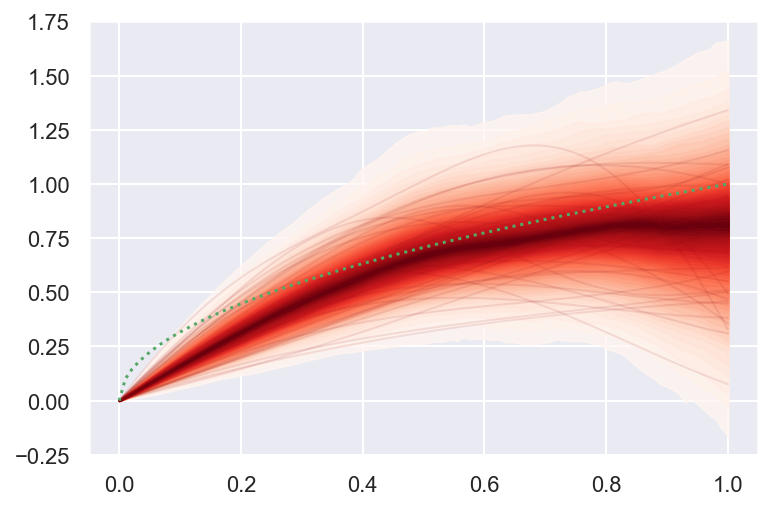

In [86]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, x_plot)
# ax.plot(X, u_model(X, theta=theta_model), ls="--");
ax.plot(x_plot, u_data(x_plot, theta=theta_data), ls=':', color="C2");

### Alternative way to make predictions

In [103]:
def kernel(X, Xs, length):
    deltaX = np.power((X[:, None] - Xs) / length, 2.0)
    return np.exp(-0.5 * deltaX)

def gp_predict_debug(X, samples_az, u, theta, Xnew=None, jitter=1.0e-6, use_ratio=True):
    
    n_sample = samples_az.posterior["kernel_var"].shape[0] * samples_az.posterior["kernel_var"].shape[1]
    
    var_samples = np.array(samples_az.posterior["kernel_var"]).reshape(n_sample, -1)
    length_samples = np.array(samples_az.posterior["kernel_length"]).reshape(n_sample, -1)
    eta_samples = np.array(samples_az.posterior["eta"]).reshape(n_sample, -1)
    
    # print(np.isnan(var_samples).any())
    # print(np.isnan(length_samples).any())
    # print(np.isnan(eta_samples).any())
    
    N = X.shape[0]
    
    if Xnew is not None:
        M = Xnew.shape[0]
        f_predict = np.zeros((n_sample, M))

    else:
        f_predict = np.zeros((n_sample, N))
        
    uX = u(X, theta_model)

    if use_ratio:
        factor = uX[:, None] * uX
    else:
        factor = 1
    
    for i in tqdm(range(n_sample)):
    
        var=var_samples[i]
        length=length_samples[i]
        eta=eta_samples[i] 

        k_XX = factor * var**2 * kernel(X, X, length) + jitter*np.eye(N)
        L = np.linalg.cholesky(k_XX)
        L_eta = L.dot(eta)
        f = uX + L_eta

        if Xnew is not None:

            up = u(Xnew, theta)
            
            # https://gregorygundersen.com/blog/2019/09/12/practical-gp-regression/
            alpha = scipy.linalg.cho_solve((L, True), f)
            
            factor_pX = up[:, None] * uX
            K_pX = factor_pX * var**2 * kernel(Xnew, X, length)
            f_pred = K_pX.dot(alpha)
            
            f_predict[i] = f_pred
            
            # https://github.com/pymc-devs/pymc3/blob/master/pymc3/gp/gp.py
            factor_Xp = uX[:, None] * up
            K_Xp = factor_Xp * var**2 * kernel(X, Xnew, length)
        
            A = scipy.linalg.solve_triangular(L, K_Xp, lower=True)
            v = scipy.linalg.solve_triangular(L, L_eta, lower=True)
            
            f_pred_original = up + A.T.dot(v)
            
            print(f_pred[:5])
            print(f_pred_original[:5])

        else:
            f_predict[i] = f
    
    return f_predict

In [104]:
x_plot = np.linspace(0, 1, 100)
f_samples = gp_predict_debug(X=stan_data["X"], samples_az=samples_az, 
                       u=u_model, theta=theta_model, use_ratio=True,
                       Xnew=x_plot)

  1%|          | 21/2000 [00:00<00:09, 203.96it/s]

[0.         0.00794118 0.01582908 0.02364723 0.03138045]
[0.         0.00801686 0.01595008 0.02378974 0.03152639]
[0.         0.01687728 0.03390805 0.05108166 0.06838724]
[0.         0.01691767 0.03397682 0.05116866 0.06848401]
[0.         0.02004515 0.04011816 0.06020317 0.0802842 ]
[0.         0.02005168 0.04012928 0.06021728 0.08029997]
[0.         0.01536588 0.0306793  0.04593835 0.06114114]
[0.         0.01538935 0.03072193 0.04599621 0.06121064]
[0.         0.0122081  0.02446441 0.03676324 0.04909893]
[0.         0.01221907 0.02448426 0.0367901  0.04913108]
[0.         0.0132099  0.02635436 0.03942112 0.05239936]
[0.         0.01324418 0.02640975 0.03948726 0.05246833]
[0.         0.01137339 0.02292999 0.0346616  0.04655994]
[0.         0.01148811 0.02312711 0.03491341 0.04684298]
[0.         0.00957802 0.01918748 0.02882771 0.03849805]
[0.         0.01004384 0.02008779 0.03013184 0.04017601]
[0.         0.00920101 0.01873491 0.02857042 0.03867743]
[0.         0.00966364 0.019466

  3%|▎         | 63/2000 [00:00<00:10, 190.03it/s]

[0.         0.01878207 0.03749768 0.05614138 0.07470763]
[0.         0.01878762 0.03750768 0.05615484 0.07472366]
[0.         0.01673058 0.03340217 0.0500112  0.06655408]
[0.         0.01673818 0.03341591 0.05002976 0.06657625]
[0.         0.01829652 0.03647195 0.0545212  0.07243966]
[0.         0.01830069 0.03647897 0.05452999 0.07244933]
[0.         0.0150554  0.03002274 0.0449015  0.05969115]
[0.         0.01506238 0.03003544 0.04491875 0.05971192]
[0.         0.01373195 0.02745585 0.04117098 0.05487667]
[0.         0.01374635 0.02748195 0.04120635 0.05491909]
[0.         0.01048188 0.02089067 0.03122643 0.04148927]
[0.         0.01048789 0.02090158 0.03124124 0.04150707]
[0.         0.02642256 0.05273549 0.0789207  0.10495991]
[0.         0.02643804 0.05276172 0.07895372 0.10499645]
[0.         0.00484648 0.00879743 0.01193135 0.01434135]
[0.         0.00486814 0.00882687 0.0119595  0.0143629 ]
[0.         0.01189702 0.02377056 0.03562032 0.04744599]
[0.         0.0119031  0.023781

  5%|▌         | 108/2000 [00:00<00:09, 197.40it/s]

[0.         0.01793634 0.03575754 0.05345416 0.07101651]
[0.         0.01793979 0.03576353 0.05346191 0.07102537]
[0.         0.01350253 0.02691288 0.04022998 0.0534528 ]
[0.         0.01350506 0.0269175  0.04023629 0.05346044]
[0.         0.01714085 0.03412742 0.05096064 0.06764146]
[0.         0.01714726 0.03413895 0.05097611 0.06765983]
[0.         0.01809315 0.03609294 0.05399622 0.07179982]
[0.         0.01810041 0.0361061  0.05401403 0.07182117]
[0.         0.01578798 0.03126811 0.04644526 0.06132442]
[0.         0.0157914  0.03127405 0.04645295 0.06133322]
[0.         0.02243233 0.04488238 0.06734165 0.08980168]
[0.         0.02244737 0.04490959 0.06737841 0.08984563]
[0.         0.01212961 0.02419002 0.0361808  0.04810156]
[0.         0.01213067 0.02419199 0.03618357 0.048105  ]
[0.         0.01810682 0.03613479 0.05407846 0.07193252]
[0.         0.01812257 0.0361633  0.05411705 0.07197875]
[0.         0.00747699 0.01490082 0.02227226 0.02959208]
[0.         0.00749044 0.014925

  8%|▊         | 151/2000 [00:00<00:09, 204.45it/s]

[0.         0.0155594  0.03102295 0.04638358 0.06163453]
[0.         0.01556549 0.03103337 0.04639684 0.0616494 ]
[0.         0.01509653 0.0300404  0.0448155  0.05940615]
[0.         0.01510702 0.03005811 0.0448377  0.05943062]
[0.         0.01423426 0.0284386  0.0426115  0.05675143]
[0.         0.01424362 0.02845557 0.04263448 0.05677899]
[0.         0.0249727  0.04968616 0.0741295  0.09829217]
[0.         0.0249822  0.0497025  0.0741504  0.09831575]
[0.         0.01825411 0.03669102 0.05529747 0.07405989]
[0.         0.01827162 0.03671843 0.05532899 0.07409129]
[0.         0.00821717 0.01644181 0.0246734  0.03291138]
[0.         0.00821825 0.01644384 0.02467624 0.03291492]
[0.         0.01294058 0.0257178  0.03832229 0.05074601]
[0.         0.01298846 0.02579456 0.03841307 0.05083956]
[0.         0.00985156 0.01971398 0.02958643 0.03946807]
[0.         0.00986415 0.01973714 0.02961828 0.0395069 ]
[0.         0.01490136 0.03107206 0.04805234 0.06509831]
[0.         0.01503953 0.031143

 10%|▉         | 197/2000 [00:00<00:08, 217.78it/s]

[0.         0.01204441 0.02424945 0.03659717 0.04906923]
[0.         0.01206833 0.0242887  0.03664488 0.04912003]
[0.         0.01927915 0.03839021 0.05733282 0.07610662]
[0.         0.0192831  0.03839736 0.0573425  0.07611822]
[0.         0.01960758 0.0391774  0.05870669 0.07819245]
[0.         0.01961624 0.03919206 0.05872514 0.07821287]
[0.         0.02224624 0.04418767 0.06582324 0.08715191]
[0.         0.02225083 0.04419599 0.06583449 0.08716539]
[0.         0.00271723 0.00614054 0.01024609 0.01500852]
[0.         0.00272703 0.00615655 0.01026547 0.01502906]
[0.         0.02679458 0.05327812 0.07944936 0.1053074 ]
[0.         0.0267986  0.05328509 0.07945837 0.10531768]
[0.         0.0207239  0.04127351 0.06164908 0.08185089]
[0.         0.02072534 0.04127612 0.06165263 0.08185517]
[0.         0.0217631  0.0439344  0.06649016 0.08940553]
[0.         0.02178034 0.04396256 0.06652423 0.08944161]
[0.         0.02185815 0.04379925 0.06580136 0.08784219]
[0.         0.02187822 0.043833

 12%|█▏        | 244/2000 [00:01<00:08, 214.93it/s]

[0.         0.02524024 0.05763722 0.09679561 0.14128478]
[0.         0.02530649 0.05765925 0.09676896 0.14124299]
[0.         0.00295216 0.00936285 0.02006079 0.03547536]
[0.         0.0030122  0.00939041 0.02004154 0.03543077]
[0.         0.00805642 0.02088708 0.03871206 0.06068903]
[0.         0.0082337  0.02094949 0.03865099 0.06059831]
[0.         0.01252722 0.02507451 0.03764555 0.05024373]
[0.         0.01258305 0.0251684  0.03776274 0.05037217]
[0.         0.01783243 0.03555718 0.0531744  0.07068426]
[0.         0.01783592 0.03556352 0.05318303 0.07069467]
[0.         0.02332885 0.04602009 0.06810086 0.08959906]
[0.         0.02333618 0.04603208 0.06811539 0.08961449]
[0.         0.01489857 0.03009646 0.04554949 0.06121297]
[0.         0.01499937 0.03025762 0.04573918 0.06140698]
[0.         0.0232035  0.04606871 0.06858761 0.09075231]
[0.         0.02320925 0.04607903 0.06860145 0.09076873]
[0.         0.01214818 0.02464328 0.03747153 0.05061875]
[0.         0.01215548 0.024655

 15%|█▍        | 291/2000 [00:01<00:07, 219.76it/s]

[0.         0.01628788 0.03259273 0.04891367 0.06524973]
[0.         0.01630828 0.03262927 0.04896255 0.0653076 ]
[0.         0.00722847 0.01433453 0.02131825 0.02817978]
[0.         0.00723594 0.01434806 0.02133656 0.02820172]
[0.         0.01294922 0.02586569 0.03874875 0.05159772]
[0.         0.01297821 0.02591793 0.03881907 0.05168152]
[0.         0.01027062 0.02053999 0.03080804 0.04107471]
[0.         0.01031321 0.02062169 0.03092551 0.04122474]
[0.         0.00956419 0.01914949 0.02875525 0.03838083]
[0.         0.00960495 0.01922425 0.0288578  0.0385055 ]
[0.         0.0100998  0.02021822 0.03035482 0.0405092 ]
[0.         0.01013828 0.02028824 0.03045003 0.04062384]
[0.         0.01091741 0.02183682 0.03275772 0.04367962]
[0.         0.01094596 0.02188969 0.032831   0.04376973]
[0.         0.01215066 0.02430621 0.03646639 0.04863095]
[0.         0.01215498 0.02431417 0.03647739 0.04864442]
[0.         0.02559118 0.0508534  0.07577176 0.10033248]
[0.         0.02561066 0.050886

 17%|█▋        | 339/2000 [00:01<00:07, 227.17it/s]

[0.         0.02597712 0.05151309 0.0766064  0.10125566]
[0.         0.0259809  0.05151992 0.07661563 0.1012667 ]
[0.         0.01540534 0.03068367 0.04583337 0.06085281]
[0.         0.01541137 0.03069465 0.04584832 0.06087085]
[0.         0.00910841 0.01818506 0.02722871 0.03623808]
[0.         0.00911418 0.01819552 0.02724287 0.03625502]
[0.         0.02009117 0.03991007 0.05944931 0.07870178]
[0.         0.02009583 0.03991817 0.05945982 0.07871382]
[0.         0.0207933  0.04152535 0.06218671 0.08276798]
[0.         0.02081239 0.04155751 0.06222693 0.08281213]
[0.         0.02289167 0.04603043 0.06939561 0.09296574]
[0.         0.02289952 0.04604359 0.06941198 0.09298359]
[0.         0.02344536 0.04713663 0.07106267 0.09521118]
[0.         0.0234642  0.04716741 0.07109992 0.09525065]
[0.         0.01648924 0.03298014 0.04946798 0.06594813]
[0.         0.0165148  0.03302269 0.04952051 0.06600504]
[0.         0.01457488 0.0291035  0.04358462 0.05801706]
[0.         0.01458285 0.029117

 19%|█▉        | 387/2000 [00:01<00:06, 231.01it/s]

[0.         0.01453335 0.02887904 0.04303625 0.05700419]
[0.         0.01453694 0.02888551 0.04304496 0.05701457]
[0.         0.02468291 0.04919752 0.07353359 0.09768097]
[0.         0.02468829 0.0492071  0.07354633 0.09769596]
[0.         0.02780414 0.05517409 0.08210733 0.1086015 ]
[0.         0.02780859 0.05518215 0.08211823 0.10861455]
[0.         0.02043502 0.0410174  0.06172501 0.08253563]
[0.         0.02044659 0.04103688 0.06174936 0.08256236]
[0.         0.0223772  0.04427879 0.06570468 0.08665492]
[0.         0.02237937 0.04428267 0.06570988 0.08666107]
[0.         0.02630823 0.0530627  0.08024539 0.10783589]
[0.         0.02631459 0.05307325 0.08025837 0.10784988]
[0.         0.0171006  0.0343115  0.0516319  0.06906149]
[0.         0.01711794 0.03433931 0.05166484 0.06909552]
[0.         0.02244654 0.04499316 0.0675991  0.09023244]
[0.         0.02247489 0.04503264 0.06763817 0.09026409]
[0.         0.00501646 0.01080801 0.01743262 0.02494202]
[0.         0.00503872 0.010842

 22%|██▏       | 436/2000 [00:02<00:06, 231.86it/s]

[0.         0.0192247  0.0383858  0.05746323 0.07643945]
[0.         0.01928167 0.03847308 0.05756105 0.07653387]
[0.         0.02706417 0.05380343 0.08020514 0.10625846]
[0.         0.02707925 0.05382769 0.08023398 0.1062884 ]
[0.         0.01206706 0.02432842 0.03677683 0.04940455]
[0.         0.01207398 0.02434017 0.03679165 0.04942099]
[0.         0.03635169 0.07215434 0.10733378 0.14182202]
[0.         0.03636944 0.07218144 0.10736402 0.14185102]
[0.         0.01880358 0.03749589 0.05607308 0.07453136]
[0.         0.01881585 0.03751802 0.05610291 0.07456695]
[0.         0.00993316 0.01988432 0.02985587 0.03985025]
[0.         0.00993846 0.01989391 0.02986886 0.0398658 ]
[0.         0.01903592 0.03807305 0.05710718 0.07613396]
[0.         0.01905548 0.03810634 0.05714928 0.07618079]
[0.         0.02000475 0.03988343 0.05959653 0.07910633]
[0.         0.02003788 0.03993548 0.05965663 0.07916645]
[0.         0.01430382 0.02847184 0.04249792 0.05637597]
[0.         0.01431379 0.028489

 24%|██▍       | 484/2000 [00:02<00:06, 230.66it/s]

[0.         0.03711079 0.07366228 0.10964209 0.14503937]
[0.         0.03711959 0.07367686 0.10966    0.14505867]
[0.         0.01971645 0.039245   0.05858152 0.07772275]
[0.         0.01975605 0.03931076 0.05866253 0.07781027]
[0.         0.02278708 0.04543295 0.06793054 0.09027291]
[0.         0.02279438 0.04544592 0.06794774 0.09029309]
[0.         0.01087248 0.02163042 0.03227334 0.04280057]
[0.         0.01087528 0.0216354  0.03227992 0.04280828]
[0.         0.02252382 0.04479081 0.06679987 0.08854993]
[0.         0.02253129 0.04480436 0.06681821 0.08857191]
[0.         0.01986998 0.03952313 0.05896724 0.07820956]
[0.         0.01987379 0.03952956 0.05897532 0.07821849]
[0.         0.02317865 0.04652052 0.06999768 0.09358175]
[0.         0.02319924 0.04655516 0.07004093 0.09362914]
[0.         0.02410536 0.04795686 0.07153275 0.09481556]
[0.         0.02413291 0.04799906 0.07158004 0.09486116]
[0.         0.0276675  0.05525053 0.08273972 0.11012547]
[0.         0.0276771  0.055266

 25%|██▌       | 508/2000 [00:02<00:06, 225.74it/s]

[0.         0.01516905 0.03031685 0.04544397 0.06055094]
[0.         0.01518027 0.03033718 0.04547148 0.0605839 ]
[0.         0.02648789 0.05260434 0.07834348 0.10369959]
[0.         0.02649099 0.05260994 0.07835106 0.10370866]
[0.         0.01331475 0.02670225 0.04015767 0.05367621]
[0.         0.013322   0.02671462 0.04017337 0.05369378]
[0.         0.02499064 0.04995362 0.07487676 0.09974787]
[0.         0.02499641 0.0499637  0.07488989 0.099763  ]
[0.         0.00977027 0.01955587 0.02935664 0.03917243]
[0.         0.00977733 0.01956869 0.02937404 0.03919335]
[0.         0.01389077 0.02769277 0.04140418 0.05502314]
[0.         0.01390739 0.02772284 0.04144483 0.05507177]
[0.         0.01587673 0.03186416 0.04795829 0.0641551 ]
[0.         0.01588116 0.03187198 0.04796861 0.06416716]
[0.         0.02737397 0.05457608 0.08158203 0.1083681 ]
[0.         0.0273796  0.05458556 0.08159388 0.10838112]
[0.         0.01881778 0.0374712  0.0559578  0.07427521]
[0.         0.01882368 0.037481

 28%|██▊       | 554/2000 [00:02<00:07, 195.58it/s]

[0.         0.01813363 0.03613329 0.05399018 0.07169556]
[0.         0.01814643 0.03615635 0.05402122 0.07173253]
[0.         0.01295551 0.02584885 0.03866495 0.0513896 ]
[0.         0.01298021 0.02588985 0.03871542 0.05144409]
[0.         0.02085641 0.04155038 0.06207766 0.08243404]
[0.         0.02086103 0.04155875 0.062089   0.08244763]
[0.         0.01036312 0.02080406 0.03131855 0.04190225]
[0.         0.01037256 0.02082117 0.03134171 0.04192999]
[0.         0.01469395 0.02939338 0.04409231 0.05878473]
[0.         0.014698   0.02940069 0.04410218 0.05879653]
[0.         0.02323273 0.04618741 0.06886328 0.09125969]
[0.         0.02324149 0.04620328 0.06888476 0.09128542]
[0.         0.01836301 0.03671785 0.05506164 0.07339146]
[0.         0.01837367 0.0367372  0.05508786 0.07342292]
[0.         0.01238412 0.02452816 0.03643515 0.04810822]
[0.         0.0123937  0.02454553 0.03645865 0.04813637]
[0.         0.0168127  0.03385285 0.05111079 0.06857656]
[0.         0.01681838 0.033862

 30%|███       | 600/2000 [00:02<00:06, 210.90it/s]

[0.         0.00954854 0.01909842 0.02865033 0.03820495]
[0.         0.00955509 0.01911031 0.02866644 0.03822429]
[0.         0.02254259 0.04471412 0.06651264 0.08793649]
[0.         0.02254641 0.04472061 0.06652084 0.0879456 ]
[0.         0.01756461 0.03495472 0.05216043 0.06917201]
[0.         0.01757027 0.0349648  0.05217383 0.06918778]
[0.         0.02140961 0.04272493 0.06394098 0.0850528 ]
[0.         0.02141858 0.04274113 0.06396286 0.08507896]
[0.         0.01247449 0.02481323 0.037016   0.04908264]
[0.         0.0124807  0.02482448 0.03703122 0.04910088]
[0.         0.03453883 0.06808135 0.10063288 0.1321992 ]
[0.         0.03454031 0.06808398 0.10063636 0.13220329]
[0.         0.01113122 0.02224099 0.03332968 0.04439767]
[0.         0.01113376 0.02224563 0.03333602 0.04440534]
[0.         0.02504015 0.04991041 0.07460227 0.09910719]
[0.         0.02504251 0.04991458 0.07460776 0.09911361]
[0.         0.01796348 0.03591059 0.05381719 0.07165949]
[0.         0.01796977 0.035921

 32%|███▏      | 645/2000 [00:03<00:06, 213.84it/s]

[0.         0.02335812 0.04661923 0.06977844 0.09283093]
[0.         0.02337111 0.04664256 0.06980974 0.09286809]
[0.         0.01812668 0.03572272 0.05279499 0.06935046]
[0.         0.01813036 0.03572897 0.05280288 0.06935923]
[0.         0.02910708 0.05770399 0.08578964 0.11336296]
[0.         0.02911114 0.05771135 0.08579959 0.11337487]
[0.         0.01375892 0.02750731 0.04123693 0.05493954]
[0.         0.013763   0.02751467 0.04124685 0.05495137]
[0.         0.02222632 0.04420633 0.06593634 0.0874128 ]
[0.         0.02223109 0.04421482 0.06594761 0.08742604]
[0.         0.01239971 0.02484415 0.03732732 0.04984322]
[0.         0.01240443 0.0248526  0.03733861 0.04985657]
[0.         0.0173531  0.0345768  0.05166088 0.06859551]
[0.         0.01736396 0.03459518 0.05168402 0.06862111]
[0.         0.02225248 0.04449661 0.06672357 0.0889243 ]
[0.         0.02225736 0.04450496 0.06673419 0.0889362 ]
[0.         0.02336979 0.04663959 0.06980079 0.09284468]
[0.         0.02337726 0.046652

 34%|███▍      | 689/2000 [00:03<00:06, 211.97it/s]

[0.         0.00694914 0.01382336 0.02062264 0.02734696]
[0.         0.00695005 0.01382505 0.02062498 0.02734983]
[0.         0.00984924 0.01976844 0.029753   0.03979839]
[0.         0.01030915 0.02062031 0.0309334  0.04124832]
[0.         0.01054603 0.02117485 0.03188045 0.04265698]
[0.         0.01079669 0.02162719 0.03249034 0.04338491]
[0.         0.00938443 0.01846066 0.02725871 0.03582725]
[0.         0.00948144 0.01856383 0.02732275 0.035839  ]
[0.         0.01519679 0.03063333 0.04629644 0.06217265]
[0.         0.01520096 0.03064072 0.0463062  0.06218406]
[0.         0.0199875  0.03957798 0.05877185 0.07756969]
[0.         0.01999153 0.03958526 0.05878167 0.07758142]
[0.         0.01690987 0.03375215 0.05051494 0.06718662]
[0.         0.01691496 0.03376077 0.05052578 0.06719862]
[0.         0.00544541 0.011127   0.01704228 0.0231885 ]
[0.         0.00544839 0.01113234 0.01704942 0.02319697]
[0.         0.02525135 0.05015681 0.07471553 0.09892681]
[0.         0.02526125 0.050174

 37%|███▋      | 733/2000 [00:03<00:05, 213.33it/s]

[0.         0.02036805 0.04084359 0.06139836 0.08200419]
[0.         0.02037713 0.04085885 0.06141737 0.08202497]
[0.         0.014863   0.02970311 0.04451965 0.0593119 ]
[0.         0.01486841 0.02971295 0.044533   0.05932796]
[0.         0.02779294 0.05549603 0.08310127 0.11060068]
[0.         0.02779536 0.05550037 0.08310706 0.11060754]
[0.         0.02909215 0.05808254 0.08695566 0.11569593]
[0.         0.02909535 0.05808807 0.08696276 0.11570398]
[0.         0.01860717 0.03720112 0.05576289 0.07427352]
[0.         0.01864615 0.03726719 0.05584604 0.07436545]
[0.         0.00909302 0.01818558 0.02727761 0.03636903]
[0.         0.00909469 0.01818871 0.027282   0.0363745 ]
[0.         0.00907821 0.01804217 0.02689091 0.03562347]
[0.         0.00908347 0.0180517  0.02690381 0.03563892]
[0.         0.01228399 0.02454007 0.03676813 0.04896806]
[0.         0.0122896  0.02455037 0.03678228 0.0489853 ]
[0.         0.01019495 0.02040525 0.0306293  0.04086557]
[0.         0.01027827 0.020557

 39%|███▉      | 778/2000 [00:03<00:05, 216.95it/s]

[0.         0.01388029 0.02762754 0.04124326 0.05472897]
[0.         0.01388602 0.02763793 0.04125733 0.05474583]
[0.         0.01361283 0.02699684 0.04015459 0.05308862]
[0.         0.01361509 0.02700094 0.04016014 0.05309528]
[0.         0.01919721 0.03846581 0.05779928 0.07719086]
[0.         0.01920806 0.03848507 0.0578248  0.07722078]
[0.         0.0084441  0.0169018  0.02537311 0.03385799]
[0.         0.00847182 0.016952   0.02544103 0.03393933]
[0.         0.01790993 0.03569751 0.05335822 0.07088773]
[0.         0.01792636 0.03572627 0.05339578 0.07093108]
[0.         0.00541401 0.01092695 0.01653996 0.02225416]
[0.         0.00541728 0.01093288 0.016548   0.0222638 ]
[0.         0.01096775 0.02196735 0.03299578 0.0440501 ]
[0.         0.01110812 0.02222357 0.03334531 0.04447232]
[0.         0.00961551 0.0192279  0.02883705 0.03844281]
[0.         0.00962011 0.01923658 0.02884931 0.03845822]
[0.         0.01063537 0.02133258 0.03208853 0.04290012]
[0.         0.01066032 0.021377

 41%|████      | 823/2000 [00:03<00:05, 211.61it/s]

[0.         0.03357862 0.06701612 0.10030269 0.1334281 ]
[0.         0.03358075 0.06701972 0.10030723 0.13343312]
[0.         0.01906863 0.03774329 0.05602312 0.07390728]
[0.         0.01907315 0.03775143 0.05603405 0.07392028]
[0.         0.03054452 0.06071031 0.09049107 0.11988139]
[0.         0.03055531 0.06072788 0.09051227 0.11990377]
[0.         0.02734673 0.05434573 0.08099614 0.10729723]
[0.         0.02735259 0.05435627 0.08101032 0.10731411]
[0.         0.01164778 0.02326221 0.03483963 0.04637637]
[0.         0.0116533  0.0232722  0.03485315 0.04639257]
[0.         0.02713606 0.05392302 0.08035794 0.10643805]
[0.         0.02714281 0.05393522 0.08037444 0.10645782]
[0.         0.00842591 0.01755093 0.02738775 0.03794665]
[0.         0.00843957 0.01757373 0.02741601 0.03797737]
[0.         0.0210929  0.0421876  0.06327554 0.08434809]
[0.         0.02110219 0.04220419 0.06329767 0.08437423]
[0.         0.01402545 0.02794954 0.04177304 0.05549671]
[0.         0.01402756 0.027953

 43%|████▎     | 856/2000 [00:04<00:05, 213.48it/s]

[0.         0.02105509 0.04198001 0.06277008 0.08342056]
[0.         0.02105843 0.04198591 0.06277785 0.0834296 ]
[0.         0.02475738 0.0492329  0.07342158 0.0973185 ]
[0.         0.02476033 0.04923823 0.07342876 0.09732709]
[0.         0.02168985 0.04312681 0.06430309 0.08521097]
[0.         0.02169275 0.04313192 0.06430979 0.08521875]
[0.         0.02382462 0.04738605 0.07067512 0.09368278]
[0.         0.02382735 0.04739093 0.07068163 0.09369046]
[0.         0.01294882 0.02588804 0.03881721 0.05173587]
[0.         0.01296185 0.02591169 0.03884926 0.05177434]
[0.         0.01105662 0.02201601 0.03287741 0.04364005]
[0.         0.01106116 0.02202426 0.03288861 0.0436535 ]
[0.         0.02158783 0.04274568 0.06347041 0.08375911]
[0.         0.02159322 0.04275491 0.06348219 0.08377235]
[0.         0.03471075 0.06881692 0.1022884  0.13509702]
[0.         0.0347209  0.0688339  0.10230945 0.13511993]
[0.         0.02958    0.05854727 0.08687093 0.11452226]
[0.         0.02959086 0.058565

KeyboardInterrupt: 

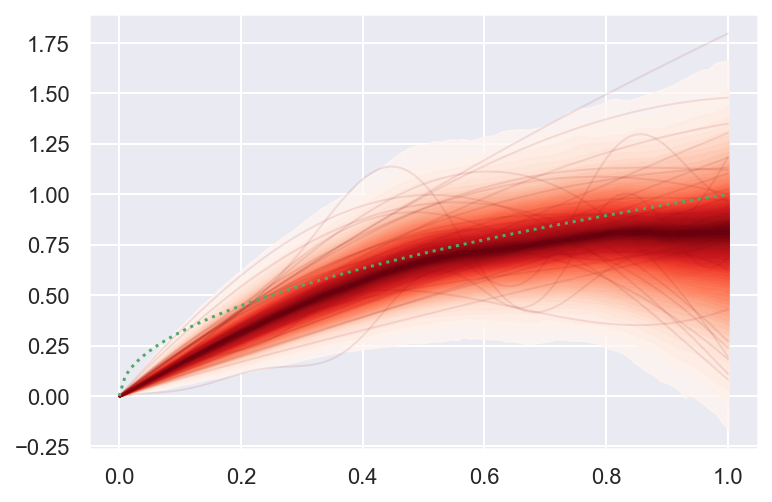

In [94]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, x_plot)
# ax.plot(X, u_model(X, theta=theta_model), ls="--");
ax.plot(x_plot, u_data(x_plot, theta=theta_data), ls=':', color="C2");

### Posterior kernel parameters

array([<AxesSubplot:title={'center':'kernel_var'}>,
       <AxesSubplot:title={'center':'kernel_length'}>], dtype=object)

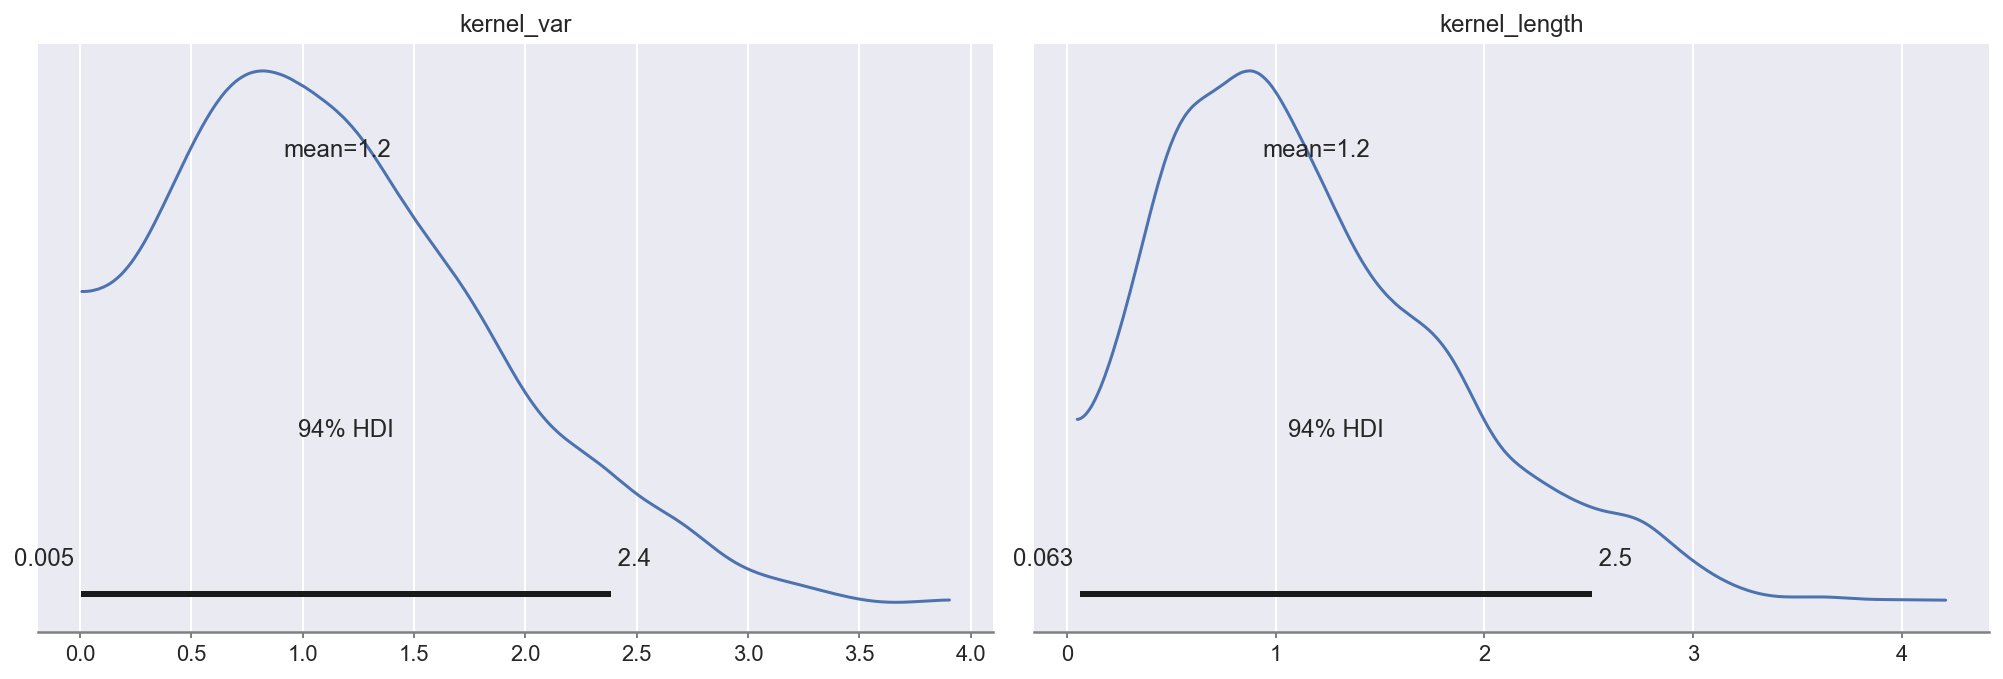

In [45]:
az.plot_posterior(trace, var_names=['kernel_var', 'kernel_length'])

## With 'true' prior

In [46]:
u_model = u_data
theta_model = theta_data
tau_model = tau_data

In [48]:
stan_data = prepare_data_for_stan(data, u=u_model, theta=theta_model, tau=tau_model)

In [49]:
trace = stan_model.sample(data=stan_data, show_progress="notebook", chains=2)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
samples_az = az.from_cmdstanpy(trace)

In [51]:
f_samples = gp_predict(X=stan_data["X"], samples_az=samples_az, 
                       u=u_model, theta=theta_model, use_ratio=True)

100%|██████████| 2000/2000 [00:02<00:00, 674.24it/s]


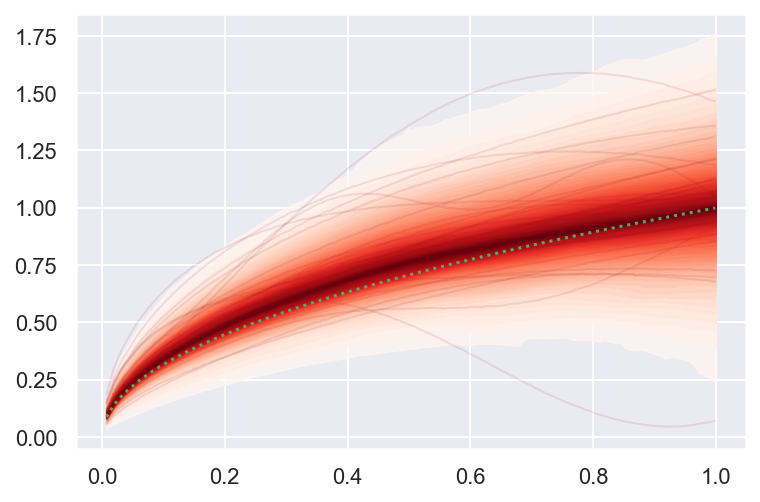

In [52]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, stan_data["X"])
# ax.plot(X, u_model(X, theta=theta_model), ls="--");
ax.plot(stan_data["X"], u_data(stan_data["X"], theta=theta_data), ls=':', color="C2");

array([<AxesSubplot:title={'center':'kernel_var'}>,
       <AxesSubplot:title={'center':'kernel_length'}>], dtype=object)

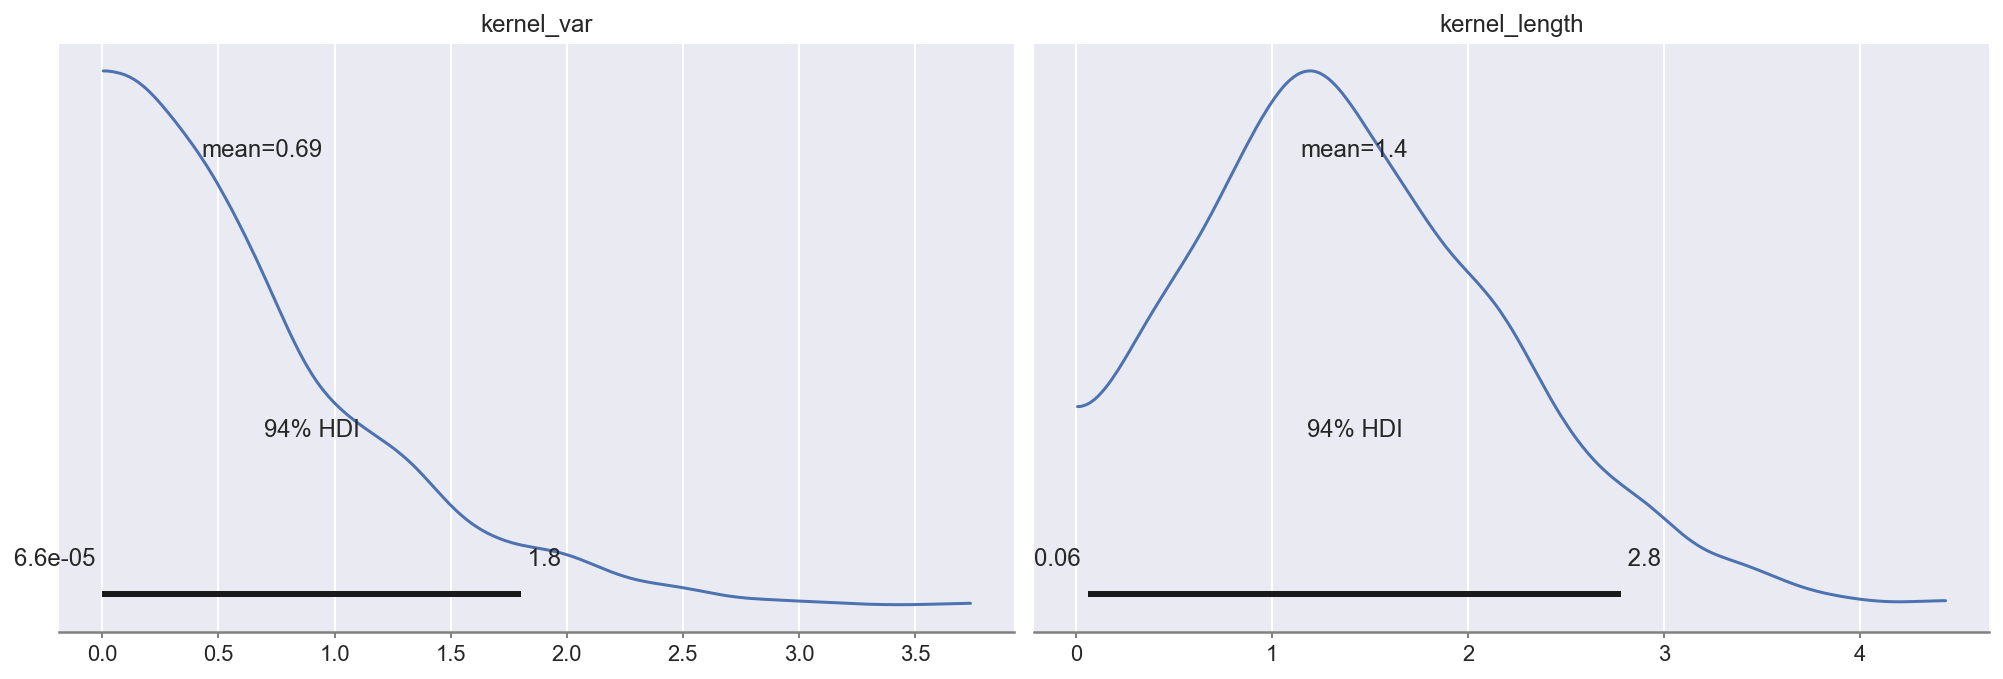

In [53]:
az.plot_posterior(trace, var_names=['kernel_var', 'kernel_length'])

# Sparse

In [81]:
%%stan -f sparse_gp_model.stan -v sparse_model --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
functions {
  vector u_pow(vector x, real theta) {
    return pow(x, theta); 
  }
} 

data {
  int<lower=0> N;
  int<lower=0> N_y;
  vector<lower=0, upper=1>[N] p;
  vector[N] X;
  int<lower=0, upper=1> y[N_y];
  int belong0[N_y];
  int belong1[N_y];
  real theta;
  real tau;
  real jitter;
  int M;
  int<lower=0, upper=1> u_model_index;
}
transformed data {
  matrix[M, M] diag_jitter;
  diag_jitter = diag_matrix(rep_vector(jitter, M));
  real X_array[N];
  X_array = to_array_1d(X);
}
parameters {
  real<lower=0> kernel_length;
  real<lower=0> kernel_var; 
  vector[M] eta;
  vector<lower=0, upper=1>[M] Xm;
}
transformed parameters{
}
model {
  vector[N] seu;
  vector[N_y] seu0;
  vector[N_y] seu1;
  vector[N] Mp;
  vector[N] f_predict;
  vector[N_y] diff_eu;
  matrix[M, M] L;
  matrix[M, M] K;
  vector[M] f;
  matrix[M, N] K_mp;
  vector[M] Mm;
  vector[M] L_dot_eta;
  matrix[M, N] A;
  vector[M] v;
  
  matrix[M, M] K_factor;
  matrix[M, N] K_mp_factor;
  
  real Xm_array[M];
  
  Xm_array = to_array_1d(Xm);
  
  kernel_length ~ normal(1, 1);
  kernel_var ~ normal(1, 1);
  eta ~ std_normal();
  Xm ~ uniform(0, 1);
  
  if (u_model_index == 0) {
    Mm = Xm;
    Mp = X;
  }
  else if (u_model_index == 1) {
    Mm = u_pow(Xm, theta);
    Mp = u_pow(X, theta);
  }
  else {
    reject("u_model_index incorrect", u_model_index);
  }
  
  K_factor = Mm*Mm';
  K_mp_factor = Mm*Mp';

  K = K_factor .* gp_exp_quad_cov(to_array_1d(Xm), kernel_var, kernel_length) + diag_jitter;
  L = cholesky_decompose(K);

  L_dot_eta = L*eta;
  f = Mm + L_dot_eta;

  K_mp = K_mp_factor .* gp_exp_quad_cov(Xm_array, X_array, kernel_var, kernel_length);
  A = mdivide_left_tri_low(L, K_mp);
  v = mdivide_left_tri_low(L, L_dot_eta);

  f_predict = Mp + A' * v;

  seu = p .* f_predict;
  seu0 = seu[belong0];
  seu1 = seu[belong1];
  diff_eu = seu1 - seu0;
  y ~ bernoulli_logit(tau * diff_eu);
}
generated quantities {
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/180343df-4a27-4d6a-88ec-5b2e7278fff5.cpp sparse_gp_model.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in sparse_model object.
Type sparse_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^
Access model compile output properties
sparse_model.model_file -> Name of stan_file [sparse_gp_model.stan]
sparse_model.model_name -> Name of stan model [sparse_gp_model_model]
sparse_model.model_code -> Model code [functions {   vector ....]


In [82]:
stan_sparse_model = stan.CmdStanModel(stan_file=sparse_model.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/sparse_gp_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/sparse_gp_model


In [91]:
def prepare_data_for_stan_sparse(data, tau, u=u_lin, theta=None, M=50):

    try:
        u_model_index = {u_lin: 0, u_pow: 1}[u]
    except KeyError:
        raise ValueError(f"Utility function {u.__name__} not recognized")
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    N = len(x)
    N_y = len(y)
    belong0 = undo_sorted[:N_y]
    belong1 = undo_sorted[N_y:]

    return {
        'tau': tau,
        'theta': theta,
        'p': p_sorted,
        'X': x_sorted,
        'y': y,
        'N_y': len(y),
        'N': len(x),
        'jitter': 1e-06,
        'belong0': belong0 + 1,
        'belong1': belong1 + 1,
        'M': M,
        'u_model_index': u_model_index
    } 

In [76]:
def kernel(X, Xs, length):
    deltaX = np.power((X[:, None] - Xs) / length, 2.0)
    return np.exp(-0.5 * deltaX)

def sparse_gp_predict(Xnew, samples_az, u, theta, jitter=1.0e-6, use_ratio=True):
    
    n_sample = samples_az.posterior["kernel_var"].shape[0] * samples_az.posterior["kernel_var"].shape[1]
    
    var_sp = np.array(samples_az.posterior["kernel_var"]).reshape(n_sample, -1)
    length_sp = np.array(samples_az.posterior["kernel_length"]).reshape(n_sample, -1)
    eta_sp = np.array(samples_az.posterior["eta"]).reshape(n_sample, -1)
    Xm_sp = np.array(samples_az.posterior["Xm"]).reshape(n_sample, -1)
    
    # print(np.isnan(var_samples).any())
    # print(np.isnan(length_samples).any())
    # print(np.isnan(eta_samples).any())
    N = Xnew.shape[0]
    f_predict = np.zeros((n_sample, N))
    
    for i in tqdm(range(n_sample)):
    
        var = var_sp[i]
        length = length_sp[i]
        eta = eta_sp[i] 
        X = Xm_sp[i]
        
        uX = u(X, theta)
        
        if use_ratio:
            factor = uX[:, None] * uX
        else:
            factor = 1
        
        M = X.shape[0]
        
        k_XX = factor * var**2 * kernel(X, X, length) + jitter*np.eye(M)
        L = np.linalg.cholesky(k_XX)
        L_dot_eta = L.dot(eta)
        f = uX + L_dot_eta


        up = u(Xnew, theta)
        if use_ratio:
            factor_Xp = uX[:, None] * up
        else:
            factor_Xp = 1
        
        K_Xp = factor_Xp * var**2 * kernel(X, Xnew, length)

        A = scipy.linalg.solve_triangular(L, K_Xp, lower=True)
        v = scipy.linalg.solve_triangular(L, L_dot_eta, lower=True)

        f_predict[i] = up + A.T.dot(v)

    return f_predict

## Using good prior

In [64]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

In [65]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(n=300, replace=False)

In [66]:
optimize(data, u_m=u_pow)

array([4.00085189, 0.48760549])

In [92]:
u_model = u_lin
theta_model = None
tau_model = 3.333
stan_sparse_data = prepare_data_for_stan_sparse(
    data, u=u_model, tau=tau_model, theta=theta_model)

In [68]:
trace = stan_sparse_model.sample(data=stan_sparse_data, show_progress="notebook", chains=2)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
samples_az = az.from_cmdstanpy(trace)

In [87]:
x_plot = np.linspace(0, 1, 100)
f_samples = sparse_gp_predict(Xnew=x_plot, samples_az=samples_az, 
                              u=u_lin, theta=None,
                              use_ratio=True)

100%|██████████| 2000/2000 [00:00<00:00, 2067.43it/s]


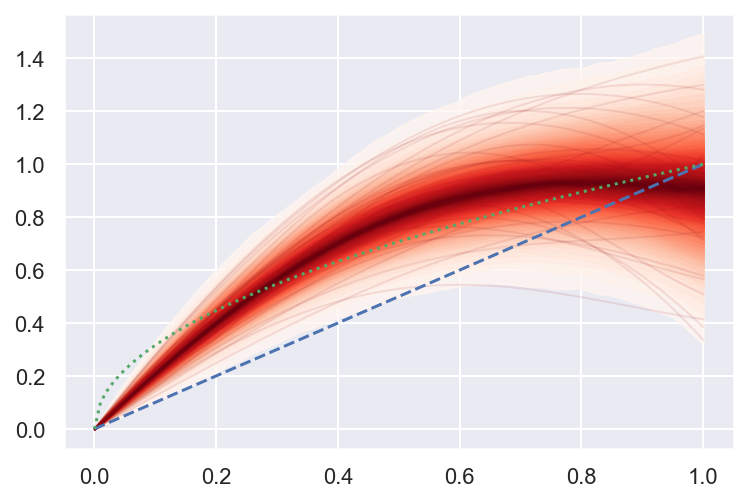

In [93]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, x_plot)
ax.plot(x_plot, u_model(x_plot, theta=theta_model), ls="--");
ax.plot(x_plot, u_data(x_plot, theta=theta_data), ls=':', color="C2");

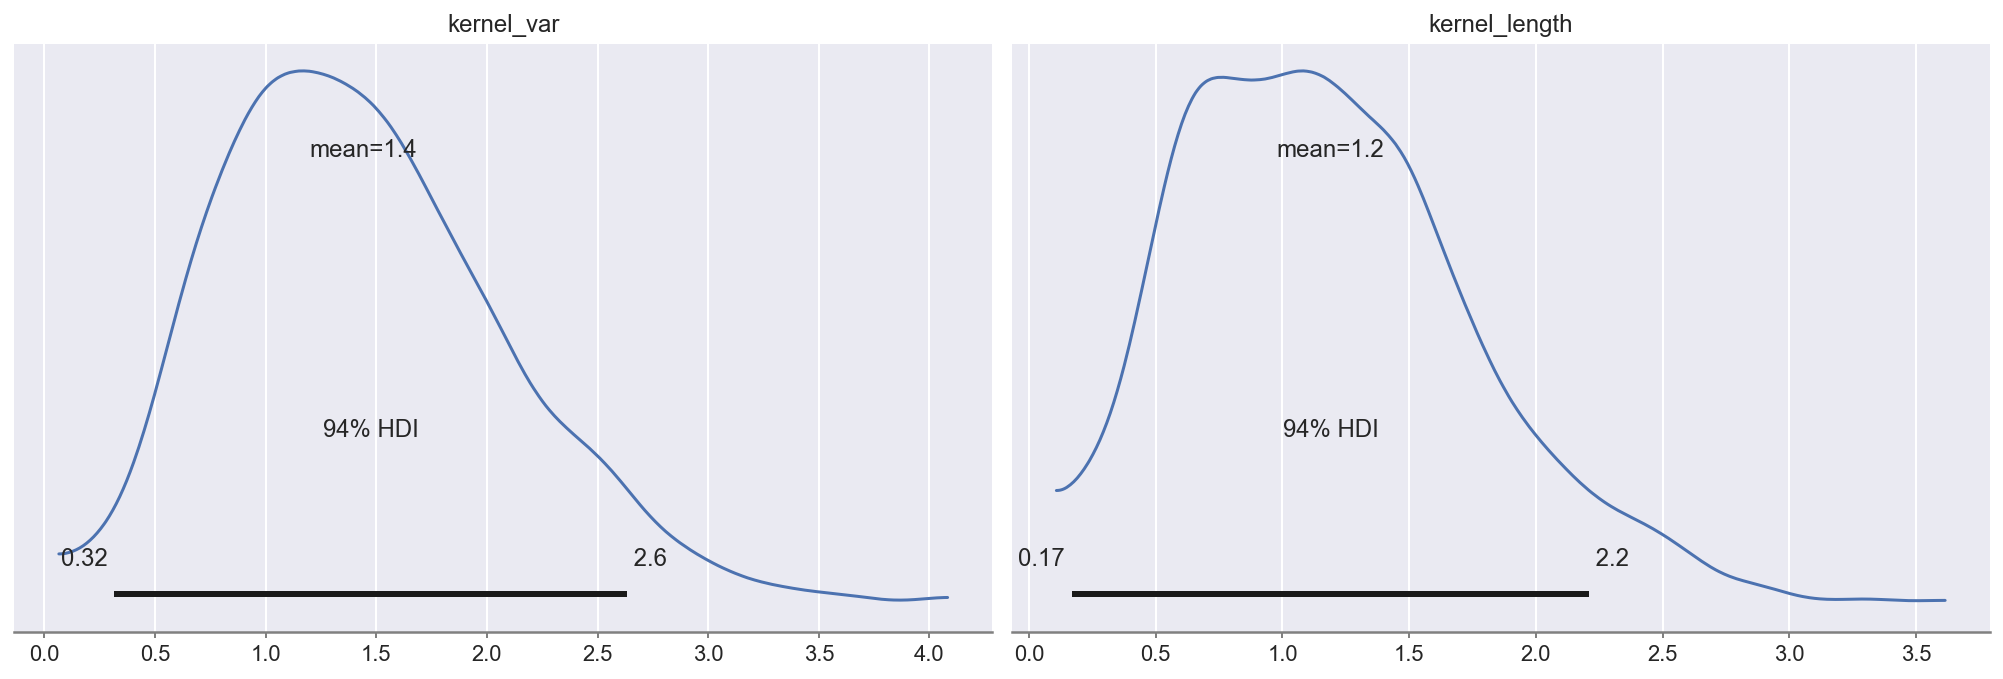

In [84]:
az.plot_posterior(samples_az, var_names=["kernel_var", "kernel_length"]);

In [80]:
trace.diagnose()

INFO:cmdstanpy:Processing csv files: /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpsq6_08f3/sparse_gp_model-202103281531-1-4t2pu_b7.csv, /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpsq6_08f3/sparse_gp_model-202103281531-2-q4tnrhc1.csv

Checking sampler transitions treedepth.
4 of 2000 (0.2%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
65 of 2000 (3.2%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values 

"Processing csv files: /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpsq6_08f3/sparse_gp_model-202103281531-1-4t2pu_b7.csv, /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpsq6_08f3/sparse_gp_model-202103281531-2-q4tnrhc1.csv\n\nChecking sampler transitions treedepth.\n4 of 2000 (0.2%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.\nTrajectories that are prematurely terminated due to this limit will result in slow exploration.\nFor optimal performance, increase this limit.\n\nChecking sampler transitions for divergences.\n65 of 2000 (3.2%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat val

## Using 'good' prior

In [94]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

In [95]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(n=300, replace=False)

In [96]:
optimize(data, u_m=u_pow)

array([4.00085189, 0.48760549])

In [97]:
u_model = u_data
theta_model = theta_data
tau_model = tau_data
stan_sparse_data = prepare_data_for_stan_sparse(
    data, u=u_model, tau=tau_model, theta=theta_model)

In [98]:
trace = stan_sparse_model.sample(data=stan_sparse_data, show_progress="notebook", chains=2)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [99]:
samples_az = az.from_cmdstanpy(trace)

In [104]:
x_plot = np.linspace(0, 1, 100)
f_samples = sparse_gp_predict(Xnew=x_plot, samples_az=samples_az, 
                              u=u_model, theta=theta_model,
                              use_ratio=True)

100%|██████████| 2000/2000 [00:01<00:00, 1351.31it/s]


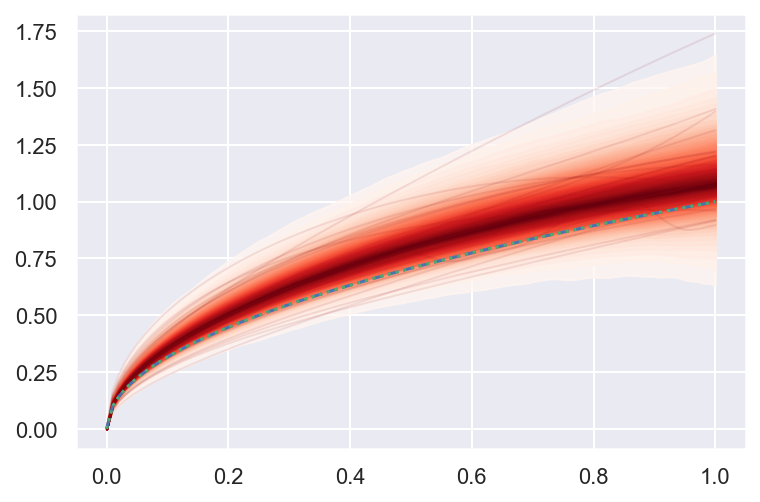

In [105]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, x_plot)
ax.plot(x_plot, u_model(x_plot, theta=theta_model), ls="--");
ax.plot(x_plot, u_data(x_plot, theta=theta_data), ls=':', color="C2");

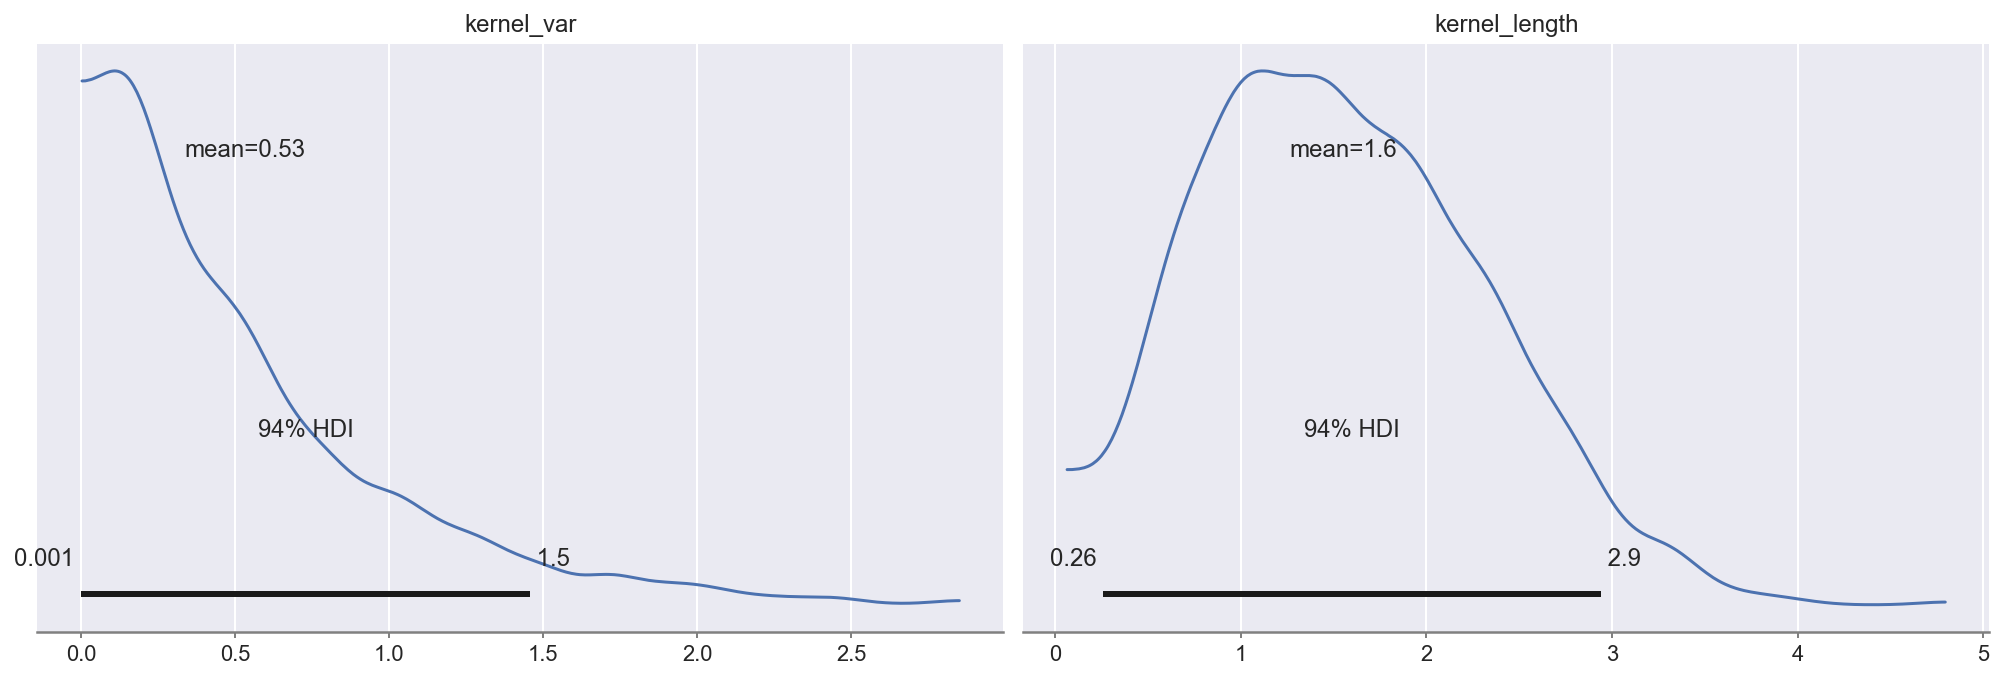

In [106]:
az.plot_posterior(samples_az, var_names=["kernel_var", "kernel_length"]);

In [107]:
trace.diagnose()

INFO:cmdstanpy:Processing csv files: /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpsq6_08f3/sparse_gp_model-202103281847-1-rzzw4wss.csv, /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpsq6_08f3/sparse_gp_model-202103281847-2-jkmvapwn.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
32 of 2000 (1.6%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


"Processing csv files: /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpsq6_08f3/sparse_gp_model-202103281847-1-rzzw4wss.csv, /var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/tmpsq6_08f3/sparse_gp_model-202103281847-2-jkmvapwn.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n32 of 2000 (1.6%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete."